In [2]:
# used to handle data
import pandas as pd

# used to handle geo data
from shapely.ops import transform, Point
from geopandas.tools import reverse_geocode
import geopandas as gpd

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

import folium

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# tells matplotlib to embed plots within the notebook
%matplotlib inline

read data

In [3]:
NYU_POIs = gpd.read_file('NYC_POIs.shp')
NYU_POIs = gpd.GeoDataFrame(NYU_POIs,crs={'init': 'epsg:4326'})
flickr = pd.read_csv('flickr_output.txt')


adding to flickr geometry column and turn into gdf

In [4]:
# creating list of x,y objects to turn into points
flickr['point'] = list(zip(flickr.X, flickr.Y))
flickr.head()

# creating geometry column from shapley points
flickr['geometry'] = flickr['point'].apply(Point)
flickr.head()

,X,Y,URL,Day,Month,Year,Date,User,Likes,Acc_level,FID,point,geometry
0,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:56:43,26946559@N02,0,Street,1,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
1,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:54:59,26946559@N02,1,Street,2,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
2,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:53:53,26946559@N02,0,Street,3,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
3,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:51:42,26946559@N02,1,Street,4,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
4,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:55:56,26946559@N02,1,Street,5,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)


In [5]:
# 'point' column is no longer needed
flickr = flickr.drop('point',1)
# turn the data frame into geodataframe
flickr = gpd.GeoDataFrame(flickr, geometry='geometry', crs={'init': 'epsg:4326'})

sanity check

<function matplotlib.pyplot.show(*args, **kw)>

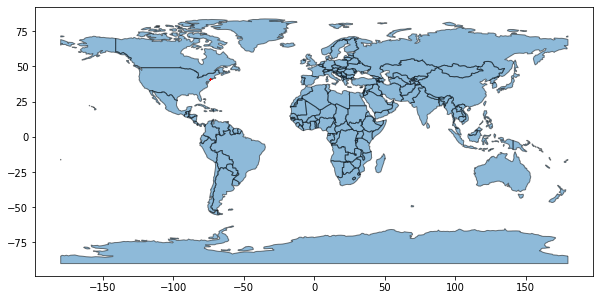

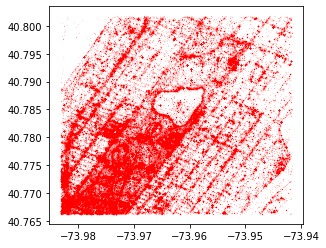

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

flickr.plot(ax=ax,color='red',alpha=0.5, markersize=0.1)
plt.show

flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show

we digitized central park boundaries in qgis and exported to shp

In [7]:
central_park_polygon = gpd.read_file('central_park_polygon.shp')


sanity check

<function matplotlib.pyplot.show(*args, **kw)>

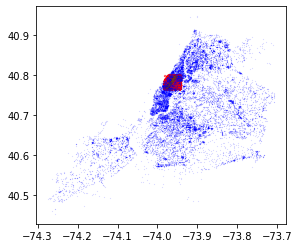

In [8]:
ax = flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show
central_park_polygon.plot(ax=ax,color='green',alpha=0.5, markersize=0.01)
plt.show
NYU_POIs.plot(ax=ax,color='blue',alpha=0.5, markersize=0.01)
plt.show

getting only the points inside central park

In [9]:
pip = NYU_POIs.within((central_park_polygon.loc[0,'geometry']))
NYU_POIs = NYU_POIs.loc[pip]
pip = flickr.within((central_park_polygon.loc[0,'geometry']))
flickr = flickr.loc[pip]

check filter results

<function matplotlib.pyplot.show(*args, **kw)>

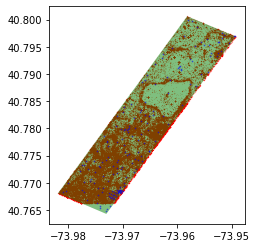

In [10]:
ax = flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show
central_park_polygon.plot(ax=ax,color='green',alpha=0.5, markersize=0.01)
plt.show
NYU_POIs.plot(ax=ax,color='blue',alpha=0.5, markersize=0.5)
plt.show

Clustering

we sample randomly 1% from the flickr data to make clustering faster

In [11]:
flickr_small = flickr.sample(frac = 0.01)

# NYU_POIs = NYU_POIs.to_crs({'init': 'epsg:32116'})
flickr_small = flickr_small.to_crs({'init': 'epsg:32116'})
flickr_small['X'] = flickr_small.geometry.values.x
flickr_small['Y'] = flickr_small.geometry.values.y

### cluster with Kmeans

finding optimal number of cluster using the knee method

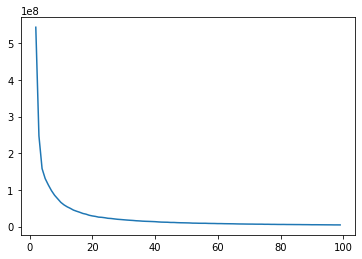

In [12]:
ssd = []
for i in range(2, 100):
    km = KMeans(n_clusters=i)
    km.fit_predict(flickr_small[['X','Y']])
    ssd.append(km.inertia_)


plt.plot(range(2,100), ssd)
plt.show()

knee is in about k=15

visualize result

<Figure size 864x576 with 0 Axes>

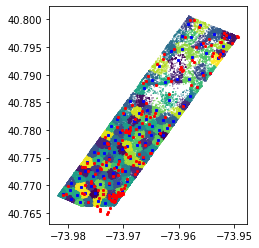

In [13]:

km = KMeans(n_clusters=100)
km.fit_predict(flickr[['X','Y']])

flickr['cluster'] = km.labels_
plt.figure(figsize=(12,8))
ax = flickr.plot(c=km.labels_, markersize=0.1)

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='blue',marker= 'X', s=5)
NYU_POIs.plot(ax=ax,color='red',marker= 'x', markersize=5)
plt.show()

### cluster with DBscan

finding optimal number of cluster using the knee method

In [14]:
flickr_small =flickr.sample(frac = 0.05)
flickr_small = flickr_small.to_crs({'init': 'epsg:32116'})
flickr_small['X'] = flickr_small.geometry.values.x
flickr_small['Y'] = flickr_small.geometry.values.y

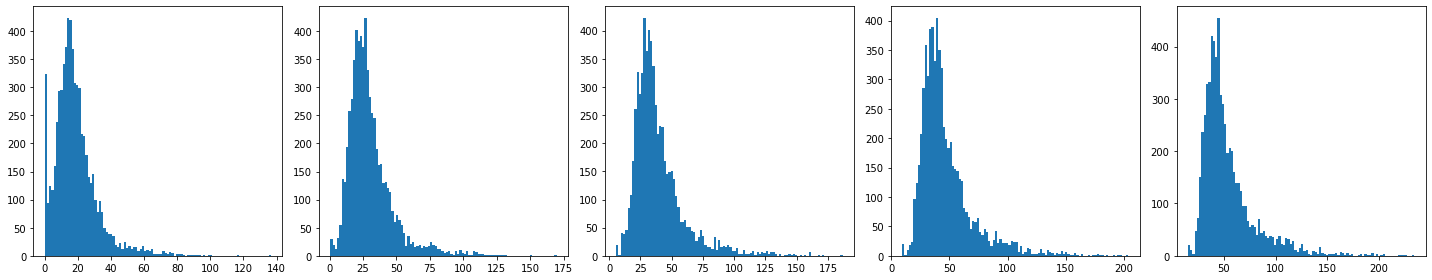

In [15]:
k = [10, 20, 30, 40, 50]
fig, axs = plt.subplots(nrows=1, ncols=5,sharey=True, figsize=(20,4))
c=1

for i in range(5):
    plt.subplot(1,5,c)
    nbrs = NearestNeighbors(n_neighbors=k[i], algorithm='ball_tree').fit(flickr_small[['X','Y']])
    distances, indices = nbrs.kneighbors(flickr_small[['X','Y']])
    avg_k_nearest_distances = np.average(distances,1)
    plt.hist(avg_k_nearest_distances,100)
    # axs[i] = plt.hist(avg_k_nearest_distances,100)
    c = c+1
fig.tight_layout()

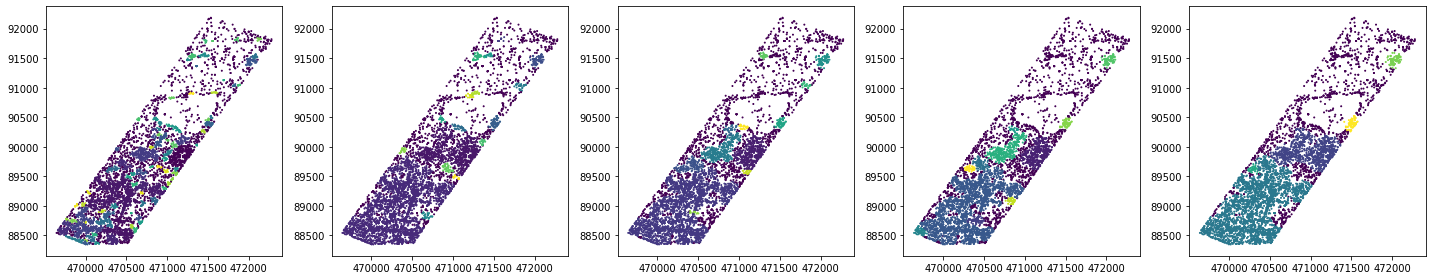

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=5,sharey=True, figsize=(20,4))
eps = [30,50,55,60,75]
# eps = [100,100,100,100,100]
c=1
for i in range(5):
    plt.subplot(1,5,c)
    db = DBSCAN(eps = eps[i], min_samples = k[i]).fit(flickr_small[['X','Y']].values)
    # flickr_small.plot(c=db.labels_, markersize=1)
    plt.scatter(flickr_small['X'],flickr_small['Y'], c=db.labels_, s=1)
    # axs[i] = plt.hist(avg_k_nearest_distances,100)
    c = c+1
fig.tight_layout()



